## Deep Deterministic Policy Gradient (DDPG)

DDPG is an actor-critic algorithm that can handle continuous action spaces effectively. It combines an actor network that learns the policy and a critic network that learns the value function. DDPG has been successfully applied to control tasks, making it a suitable choice for the inverted pendulum problem. Deep Deterministic Policy Gradient (DDPG) combines the trick for DQN with the deterministic policy gradient, to obtain an algorithm for continuous actions.

In [1]:
import gym, gym_unbalanced_disk, time
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))-np.pi

In [3]:
max_episode_steps = 300
Save_model = False
Save_figures = False
total_timesteps = 10000
log_interval = 10

target_angle = np.pi

angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.01*(((np.sin(self.th - np.pi/2)+1)/2)*(self.u)**2)

reward_lambda = lambda self: angle_reward(self) + correctVelocity_reward(self) + voltage_penalty(self)

def reward_function(self):
    q=normalise_angle(self.th)
    if (abs(q)<=np.pi/4): return 15-5*(q)**2-0.1*self.omega**2
    else: return reward_lambda(self)

env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3., reward_fun=reward_function)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

# The noise objects for DDPG
n_actions = 1
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=total_timesteps, log_interval=log_interval)

vec_env = model.get_env()

if Save_model:
    model.save("policy_ddpg")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 300       |
|    ep_rew_mean     | -1.57e+03 |
| time/              |           |
|    episodes        | 10        |
|    fps             | 62        |
|    time_elapsed    | 48        |
|    total_timesteps | 3000      |
| train/             |           |
|    actor_loss      | 58.2      |
|    critic_loss     | 1.37e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 2700      |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | -747     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 52       |
|    time_elapsed    | 113      |
|    total_timesteps | 6000     |
| train/             |          |
|    actor_loss      | 47       |
|    cr

In [4]:
render_sim = True
obs = env.reset()
u_list=[]
thetas=[]
omegas=[]
rewards=[]
try:
    for _ in range(max_episode_steps):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if render_sim:
            env.render()
        u_list.append(action)
        thetas.append(env.th)
        omegas.append(env.omega)
        rewards.append(reward)
        if render_sim:
            time.sleep(1/50)
        if done:
            obs=env.reset()
finally:
    env.close()

pygame 2.4.0 (SDL 2.26.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


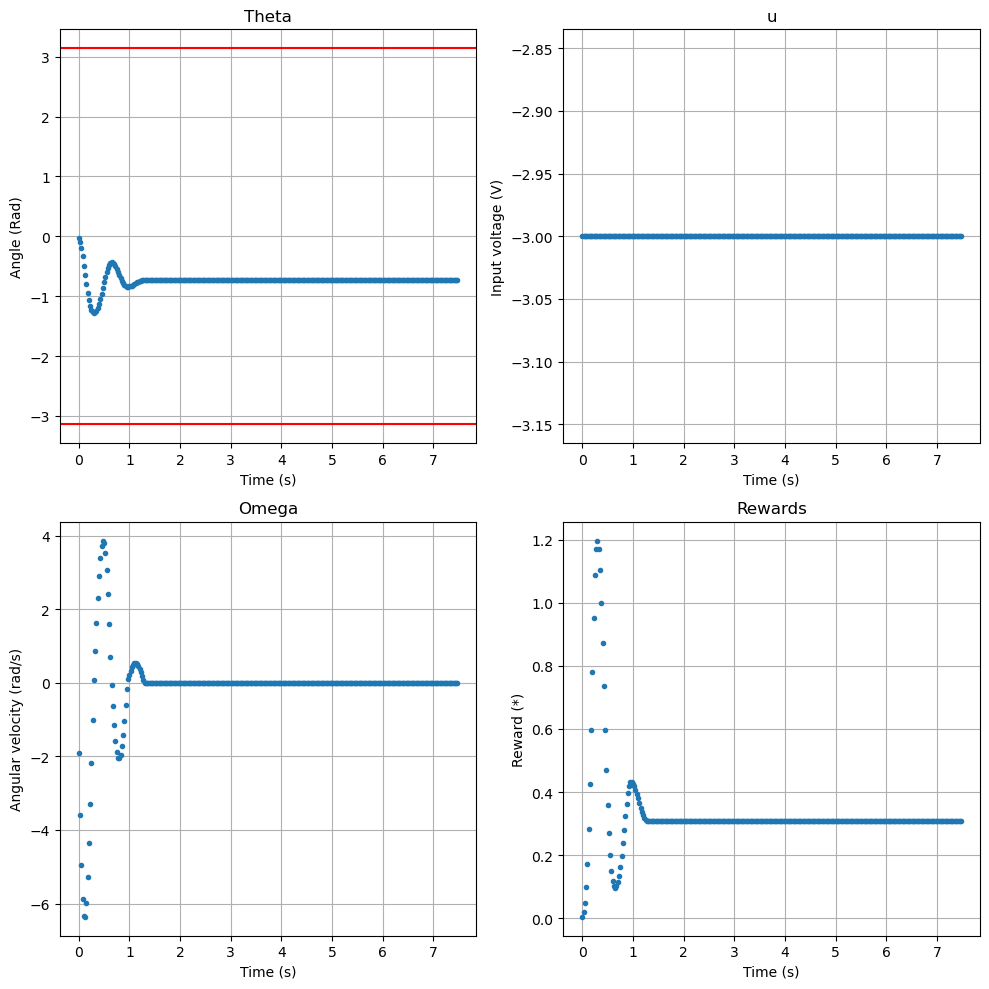

In [5]:
# Create a figure with three subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot theta
axs[0,0].plot([i*env.dt for i in range(max_episode_steps)], thetas, '.')
axs[0,0].set_title('Theta')
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Angle (Rad)')
axs[0,0].axhline(y=target_angle, color='r', linestyle='-')
axs[0,0].axhline(y=-target_angle, color='r', linestyle='-')
axs[0,0].grid(True)

# Plot u
axs[0,1].plot([i*env.dt for i in range(max_episode_steps)], u_list, '.')
axs[0,1].set_title('u')
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_ylabel('Input voltage (V)')
axs[0,1].grid(True)

# Plot omega
axs[1,0].plot([i*env.dt for i in range(max_episode_steps)], omegas, '.')
axs[1,0].set_title('Omega')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Angular velocity (rad/s)')
axs[1,0].grid(True)

# Plot omega
axs[1,1].plot([i*env.dt for i in range(max_episode_steps)], rewards, '.')
axs[1,1].set_title('Rewards')
axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylabel('Reward (*)')
axs[1,1].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

if Save_figures:
    ROOT_DIR = os.path.dirname('')
    fig.savefig(os.path.realpath(os.path.join(ROOT_DIR, os.path.splitext(fileNameSave)[0]+'FigureSimulation.eps')), format='eps')
    fig.savefig(os.path.realpath(os.path.join(ROOT_DIR, os.path.splitext(fileNameSave)[0]+'FigureSimulation.svg')))